In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime

%matplotlib inline

In [84]:
day = datetime(2020,8,18)
strat_name = "macd-rsi-sma50"

In [85]:
proj = Path(strat_name).joinpath(day.date().strftime('%Y-%m-%d'))

In [86]:
minute_data = list(proj.glob('*.csv'))

In [87]:
def format_date(x, axes, freq=20):
    ntimes = np.arange(len(x))
    times = [tm.strftime('%H:%M') for tm in x]
    axes.set_xticks(ntimes[::freq])
    axes.set_xticklabels(times[::freq], rotation=45, ha='right')
    axes.set_xlim(ntimes.min(), ntimes.max())
    return

def plot_stock(df, action_df=None, time_range='today', extension=30):
    if time_range == 'today':
        df = df[df.index.date == day.date()]
    elif time_range == 'extended':
        today_ind = np.where(df.index.date == day.date())[0][0]
        df = df[today_ind-extension:]
        
    fig, axes = plt.subplots(ncols=1, figsize=(16,7))        
    if action_df is not None:
        buys_df = action_df[action_df['Type'] == 'BUY']
        sells_df = action_df[action_df['Type'] == 'SELL']
        buys_ind = [np.where(df.index.to_pydatetime() == buy)[0][0] for buy in buys_df.index.to_pydatetime()]
        sells_ind = [np.where(df.index.to_pydatetime() == sell)[0][0] for sell in sells_df.index.to_pydatetime()]
        axes.scatter(buys_ind, buys_df['Price'], color='green', marker='^', alpha=1, s=80)
        axes.scatter(sells_ind, sells_df['Price'], color='red', marker='v', alpha=1, s=80)
        
    ind = np.arange(len(df))
    axes.plot(ind, df['Price'], label='Price')
    axes.set_title('Price History ' + symbol)
    format_date(df.index, axes, freq=5)
    axes.set_xlabel(str(day.date()) + ' Time')
    axes.set_ylabel('Price USD ($)')
    axes.grid()

    plt.show()

In [98]:
def plot_stock_with_MACD_RSI_SMA(df, action_df=None, time_range='today', extension=30):
    df['SMA50'] = df['Price'].rolling(50).mean()
    df['SMA100'] = df['Price'].rolling(100).mean()
    if time_range == 'today':
        df = df[df.index.date == day.date()]
    elif time_range == 'extended':
        today_ind = np.where(df.index.date == day.date())[0][0]
        df = df[today_ind-extension:]
        
    fig, axes = plt.subplots(nrows=3, figsize=(16,12), sharex=True, gridspec_kw={'height_ratios':[1.5,1,1]})        
    if action_df is not None:
        buys_df = action_df[action_df['Type'] == 'BUY']
        buys_df = buys_df[buys_df['Status'] == 'Completed']
        sells_df = action_df[action_df['Type'] == 'SELL']
        buys_ind = [np.where(df.index.to_pydatetime() == buy)[0][0] for buy in buys_df.index.to_pydatetime()]
        sells_ind = [np.where(df.index.to_pydatetime() == sell)[0][0] for sell in sells_df.index.to_pydatetime()]
        axes[0].scatter(buys_ind, buys_df['Price'], color='green', marker='^', alpha=1, s=80, label='buy')
        axes[0].scatter(sells_ind, sells_df['Price'], color='red', marker='v', alpha=1, s=80, label='sell')
        
    ind = np.arange(len(df))
    axes[0].plot(ind, df['Price'], label='Price')
    axes[0].plot(ind, df['SMA50'], label='SMA50', color='#14C391')
    axes[0].plot(ind, df['SMA100'], label='SMA100', color='#B844E7')    
    axes[0].set_title('Price History ' + symbol, fontsize=18)
    axes[0].set_ylabel('Price USD ($)', fontsize=16)
    axes[0].axvline(x=extension, color='k', linewidth=1)
    
    axes[1].plot(ind, df['MACD'], label='MACD')
    axes[1].plot(ind, df['Signal'], label='Signal', color='#D09B2B')
    axes[1].plot(ind, df['MACD-Dif'], label='MACD-Dif', color='#7E6010') 
    axes[1].set_ylabel('MACD', fontsize=16)
    axes[1].axhline(y=0, color='k', linewidth=1)
    axes[1].axvline(x=extension, color='k', linewidth=1)
  
    axes[2].plot(ind, df['RSI'], label='RSI')
    axes[2].set_ylabel('RSI', fontsize=16)
    axes[2].axhline(y=30, color='g', linewidth=1.5, linestyle='--')
    axes[2].axhline(y=70, color='r', linewidth=1.5, linestyle='--')
    axes[2].axvline(x=extension, color='k', linewidth=1)
    
    for ax in axes:
        ax.grid(alpha=0.7)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(3)
            ax.legend()
        
    format_date(df.index, axes[2], freq=5)
    axes[1].set_xlabel(str(day.date()) + ' Time', fontsize=16)
    plt.subplots_adjust(hspace=.0)
    plt.show() 



In [99]:
portfolio_path = list(proj.glob('00Portfolio.csv'))[0]
portfolio_df = pd.read_csv(str(portfolio_path), index_col='Time', parse_dates=True)
traded_symbols = set(portfolio_df['Symbol'])

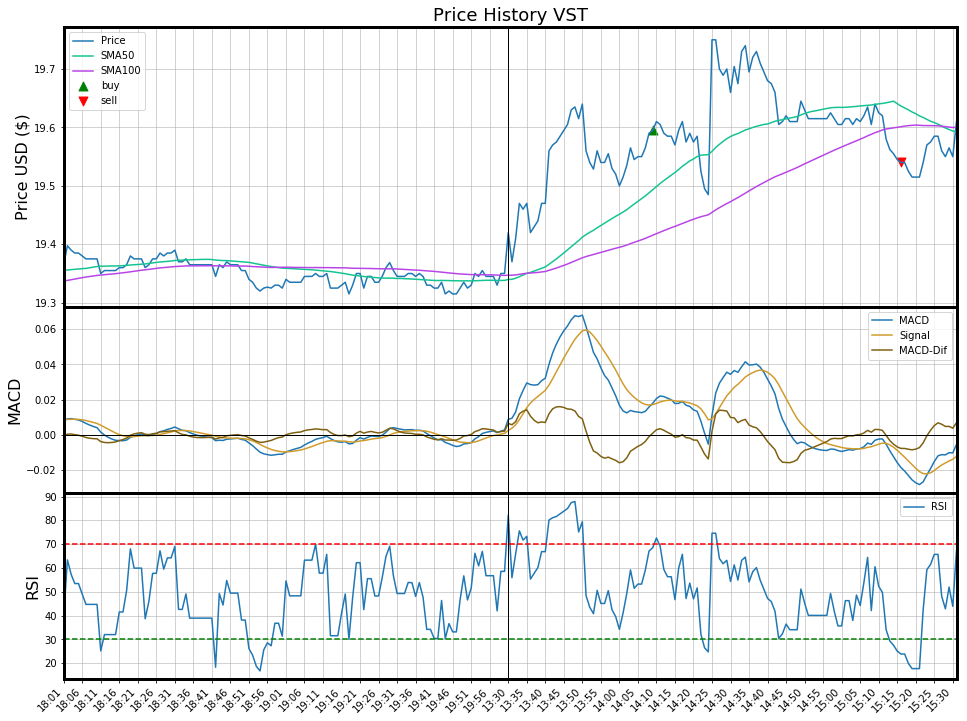

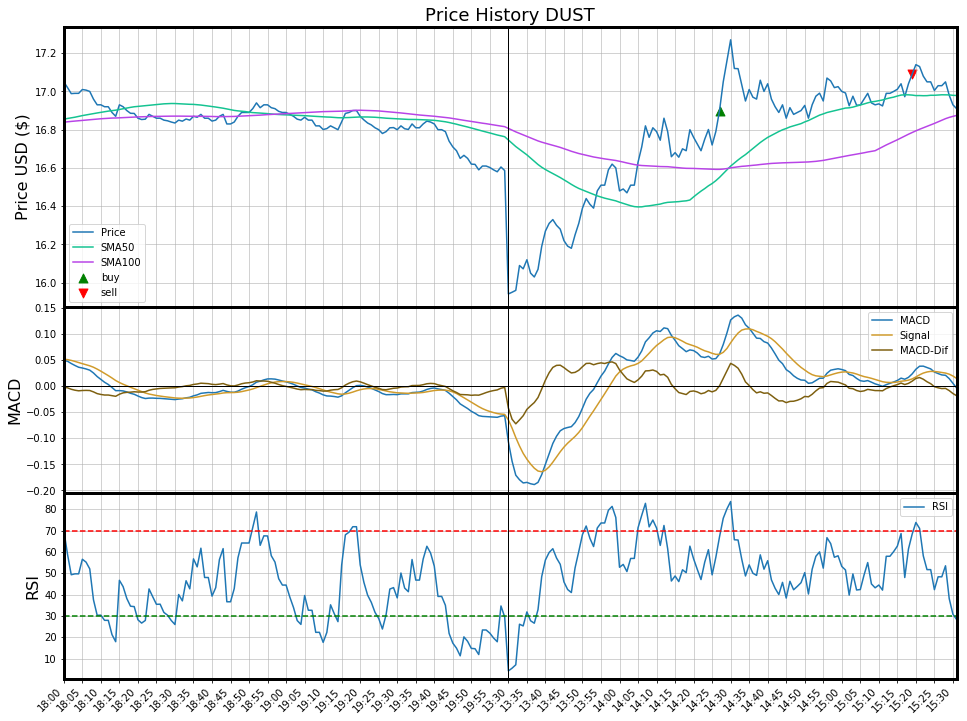

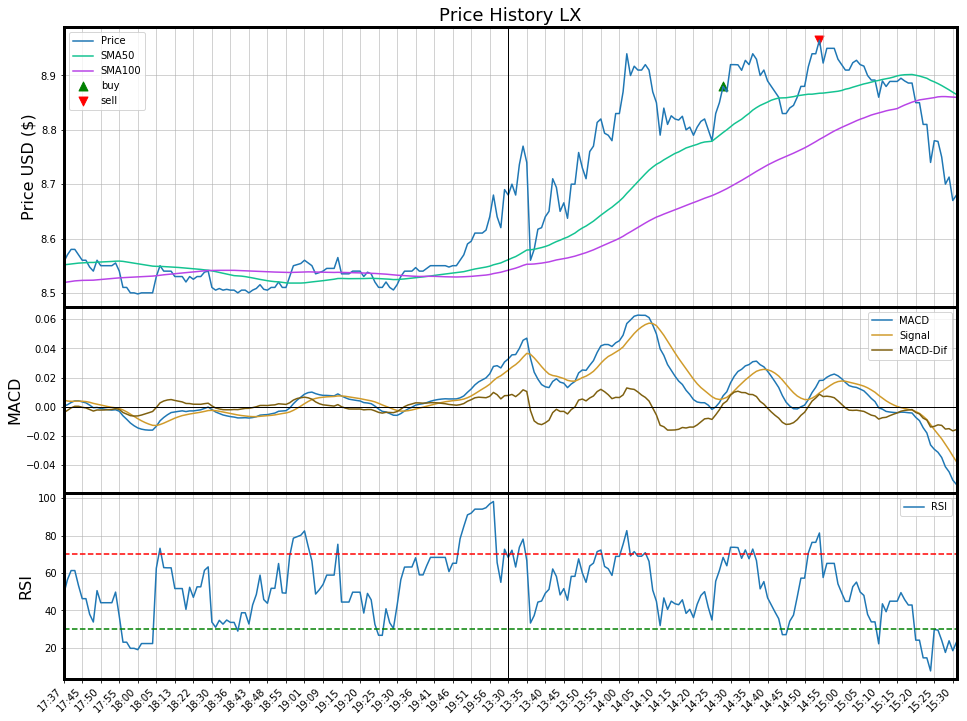

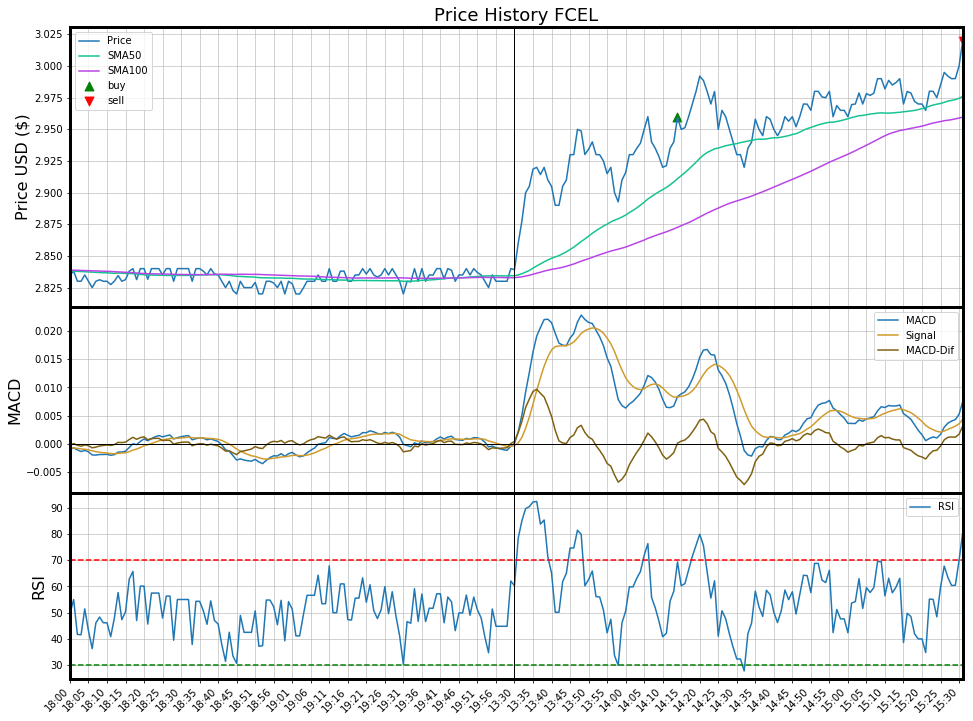

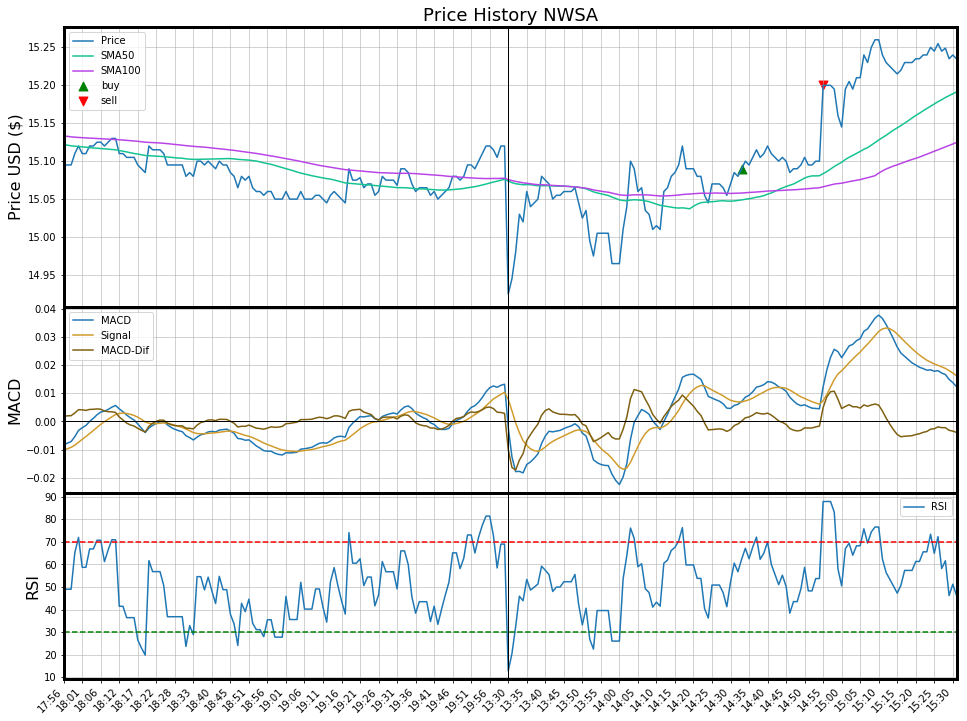

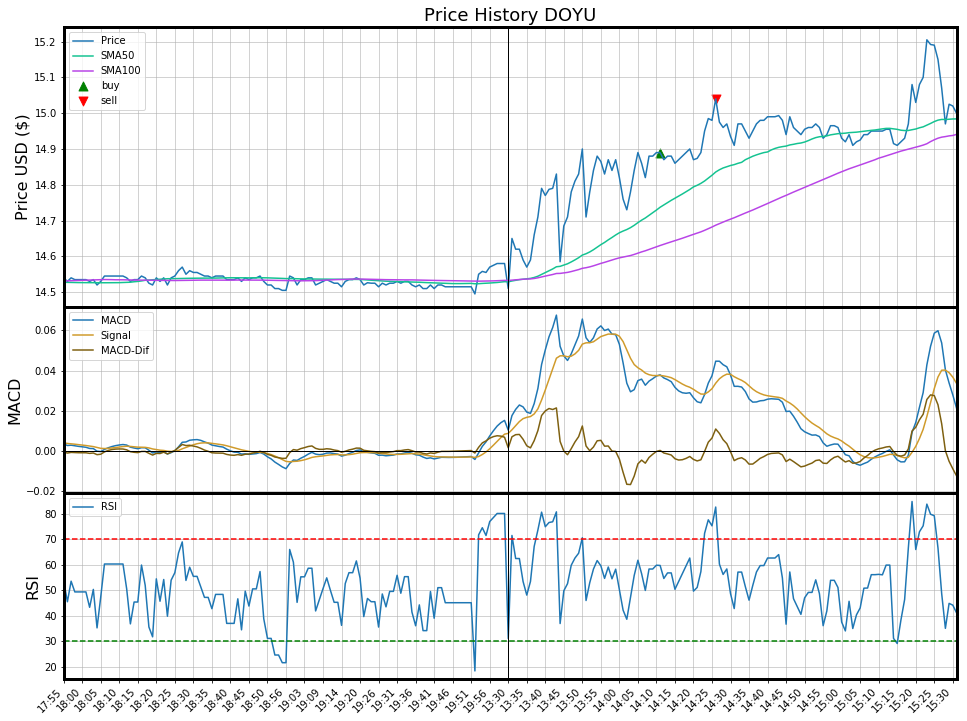

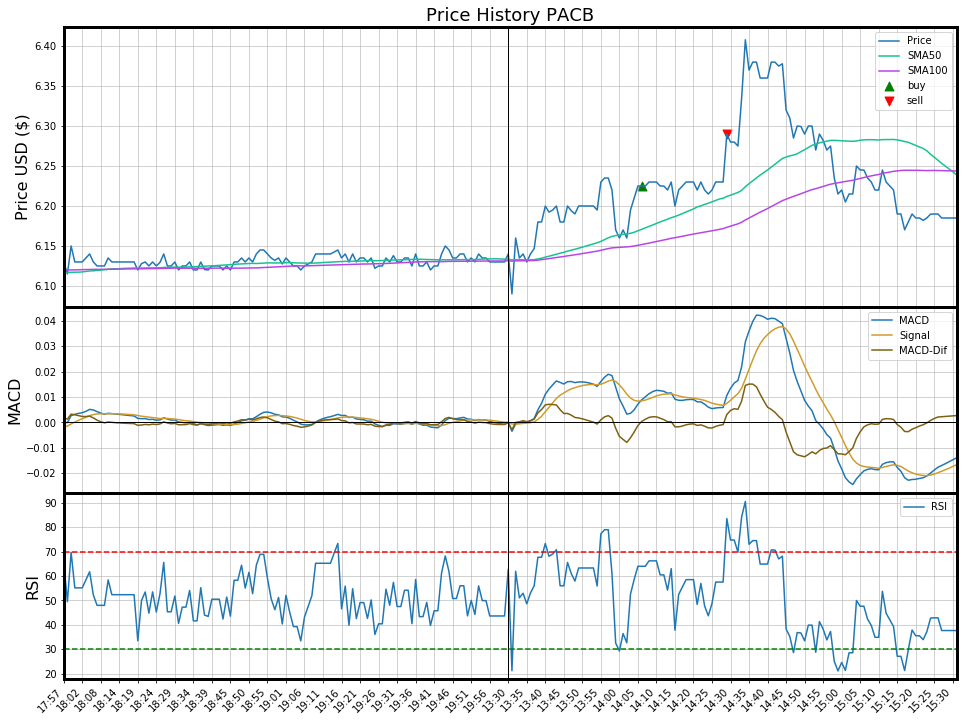

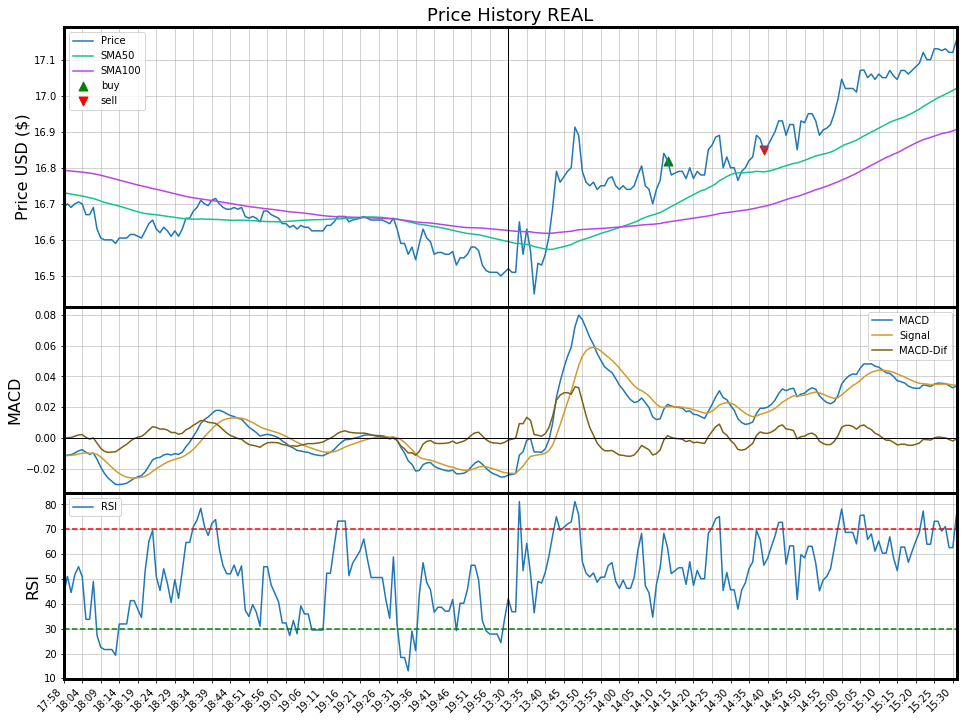

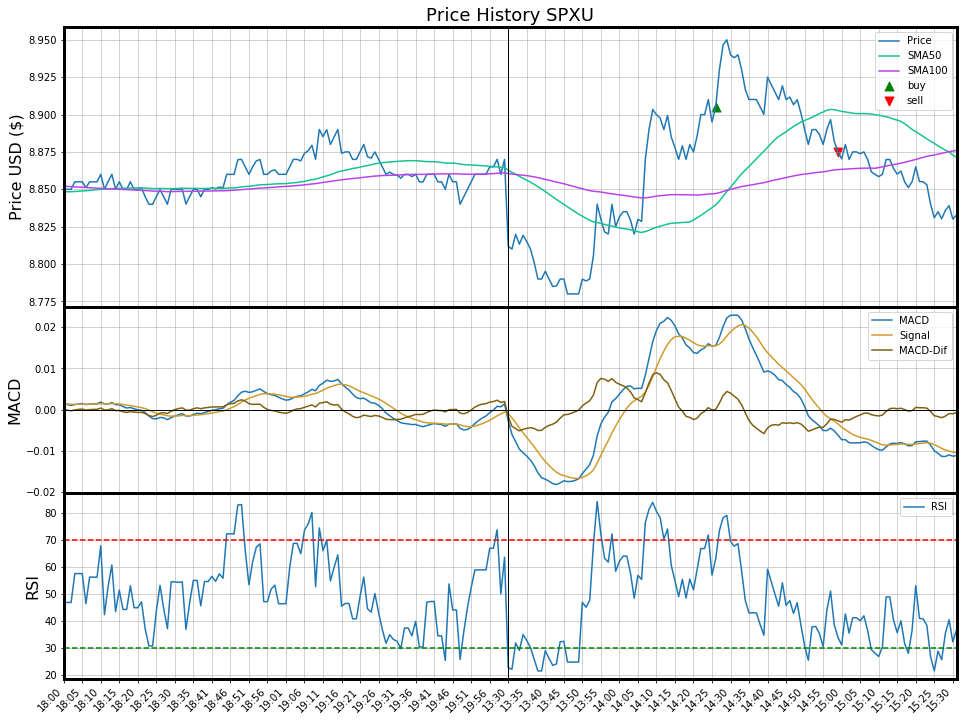

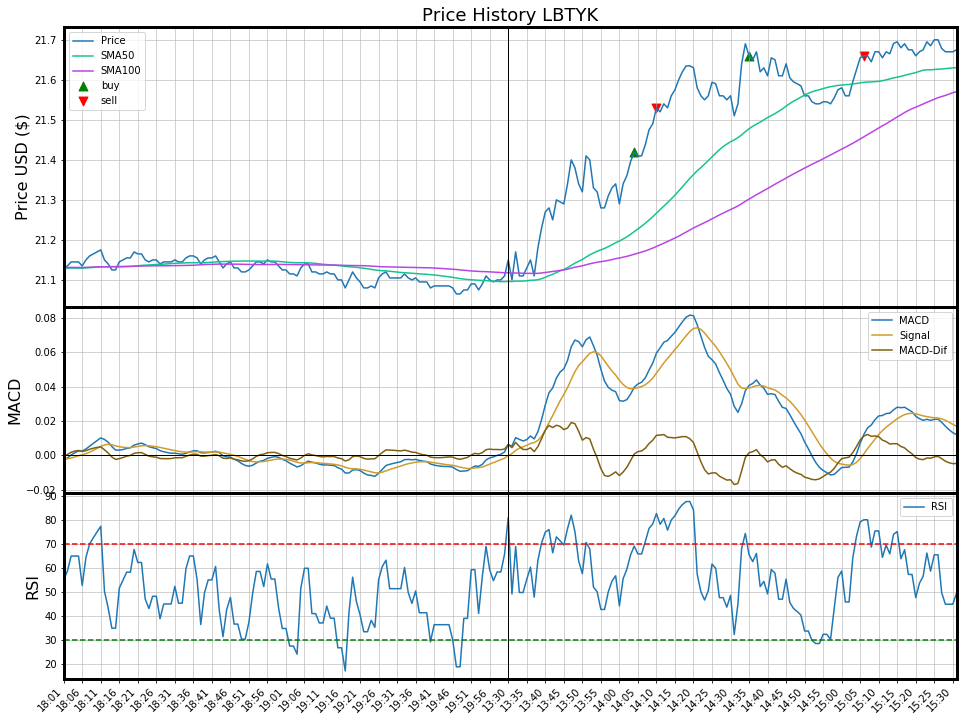

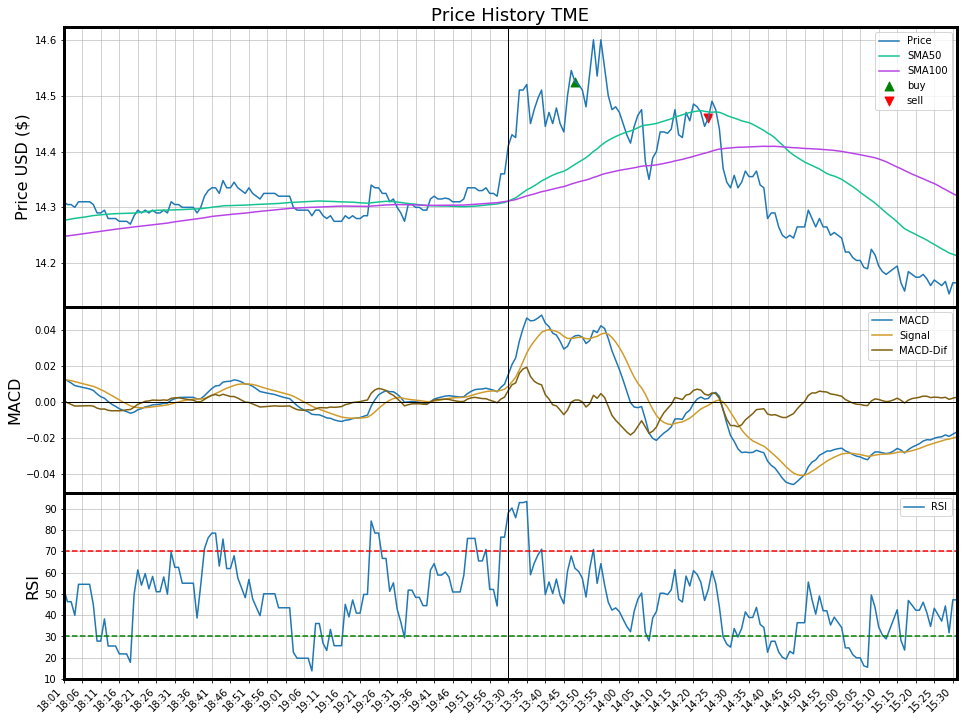

In [101]:
for symbol in traded_symbols:
    symbol_data = list(proj.glob('{}*.csv'.format(symbol)))[0]
    df = pd.read_csv(symbol_data, index_col="Time", parse_dates=True)
    symbol_df = portfolio_df[portfolio_df['Symbol'] == symbol]
    plot_stock_with_MACD_RSI_SMA(df, symbol_df, 'extended', extension=120)